In [1]:
from transformers import AutoProcessor, AutoModelForImageTextToText
from PIL import Image
import matplotlib.pyplot as plt
from accelerate import Accelerator
import re
import json
import pprint

d:\Enviroments\anaconda3\envs\day46\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
processor = AutoProcessor.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")
model = AutoModelForImageTextToText.from_pretrained("naver-clova-ix/donut-base-finetuned-cord-v2")

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [3]:
device = Accelerator().device
model.to(device)

VisionEncoderDecoderModel(
  (encoder): DonutSwinModel(
    (embeddings): DonutSwinEmbeddings(
      (patch_embeddings): DonutSwinPatchEmbeddings(
        (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      )
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DonutSwinEncoder(
      (layers): ModuleList(
        (0): DonutSwinStage(
          (blocks): ModuleList(
            (0): DonutSwinLayer(
              (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
              (attention): DonutSwinAttention(
                (self): DonutSwinSelfAttention(
                  (query): Linear(in_features=128, out_features=128, bias=True)
                  (key): Linear(in_features=128, out_features=128, bias=True)
                  (value): Linear(in_features=128, out_features=128, bias=True)
                  (dropout): Dropout(p=0.0, inplace=False)
                )

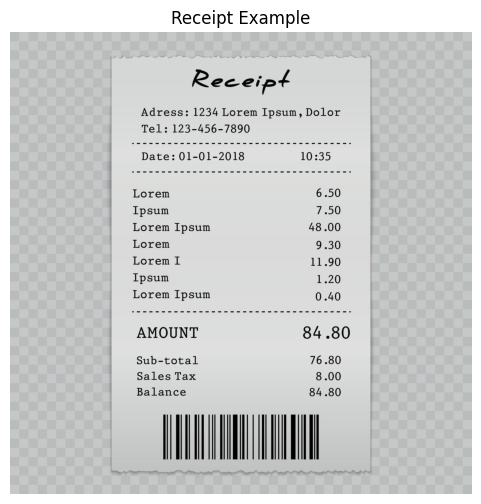

In [4]:
img_url = "../data/receipt_4.jpg"
img = Image.open(img_url).convert("RGB")

plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.title("Receipt Example")
plt.axis("off")
plt.show()

In [5]:
task_prompt = "<s_cord-v2>"
decoder_input_ids = processor.tokenizer(task_prompt, add_special_tokens=False, return_tensors="pt").input_ids
print(decoder_input_ids)

tensor([[57579]])


In [6]:
pixel_values = processor(img, return_tensors="pt").pixel_values

In [7]:
outputs = model.generate(
    pixel_values.to(device),
    decoder_input_ids=decoder_input_ids.to(device),
    max_length=model.decoder.config.max_position_embeddings,
    pad_token_id=processor.tokenizer.pad_token_id,
    eos_token_id=processor.tokenizer.eos_token_id,
    use_cache=True,
    bad_words_ids=[[processor.tokenizer.unk_token_id]],
    return_dict_in_generate=True,
)


In [8]:
decoded_sequence = processor.batch_decode(outputs.sequences)[0]
decoded_sequence = decoded_sequence.replace(processor.tokenizer.eos_token, "")
decoded_sequence = decoded_sequence.replace(processor.tokenizer.pad_token, "")
decoded_sequence = re.sub(r"<.*?>", "", decoded_sequence, count=1).strip() 
result_json = processor.token2json(decoded_sequence)

In [9]:
print(json.dumps(result_json, indent=4, ensure_ascii=False))


{
    "menu": [
        {
            "nm": "Receipt",
            "cnt": {
                "unitprice": "10:35"
            },
            "discountprice": "7.50",
            "price": "6.50"
        },
        {
            "nm": "Lorem Ipsum",
            "unitprice": "48.00",
            "cnt": "40.00",
            "price": "9.30"
        },
        {
            "nm": "Lorem I",
            "unitprice": "11.90",
            "cnt": "1.20",
            "discountprice": "0.40",
            "price": "1.20"
        }
    ],
    "sub_total": {
        "subtotal_price": "84.80",
        "tax_price": "8.00"
    },
    "total": {
        "total_price": "76.80",
        "cashprice": "84.80",
        "menuqty_cnt": "84.80"
    }
}


<p style="font-size: 18px;">
    <strong>Note:</strong> The Donuts method has to ignore any text that does not relate to the menu items or their prices first.
</p>

<p style="font-size: 18px;">
    However, this approach isn’t ideal, since most users upload receipts that are not blurred at all.
</p>